In [ ]:
#before proceeding you should run these in your python: 
#---------------------------------------------------------------------------------------------------
# pip install openmeteo-requests 
# pip install requests-cache retry-requests numpy pandas

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import scipy.stats as stats
import os
import numpy as np
import json
import requests
# from config import weatherbit_key
from pprint import pprint
from retry_requests import retry
import requests_cache
import openmeteo_requests

In [5]:
with open('descriptions.json', 'r') as f:
    data = json.load(f)
# Accessing data
code = ['weather_code']

#data[code]['day']["description"]
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 39.0376,
	"longitude": -77.4158,
	"start_date": "2000-01-01",
	"end_date": "2008-12-31",
	"hourly": ["temperature_2m", "relative_humidity_2m", "apparent_temperature", "precipitation", "rain", "snowfall", "snow_depth", "weather_code", "pressure_msl", "surface_pressure", "cloud_cover", "cloud_cover_low", "cloud_cover_mid", "cloud_cover_high", "wind_speed_10m", "wind_speed_100m", "wind_direction_10m", "wind_direction_100m", "wind_gusts_10m"],
	"daily": "weather_code",
	"temperature_unit": "fahrenheit",
	"wind_speed_unit": "mph",
	"precipitation_unit": "inch",
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(2).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(3).ValuesAsNumpy()
hourly_rain = hourly.Variables(4).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(5).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(6).ValuesAsNumpy()
hourly_weather_code = hourly.Variables(7).ValuesAsNumpy()
hourly_pressure_msl = hourly.Variables(8).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(9).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(10).ValuesAsNumpy()
hourly_cloud_cover_low = hourly.Variables(11).ValuesAsNumpy()
hourly_cloud_cover_mid = hourly.Variables(12).ValuesAsNumpy()
hourly_cloud_cover_high = hourly.Variables(13).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(14).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(15).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(16).ValuesAsNumpy()
hourly_wind_direction_100m = hourly.Variables(17).ValuesAsNumpy()
hourly_wind_gusts_10m = hourly.Variables(18).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["weather_code"] = hourly_weather_code.astype(int)
hourly_data["pressure_msl"] = hourly_pressure_msl
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["cloud_cover_low"] = hourly_cloud_cover_low
hourly_data["cloud_cover_mid"] = hourly_cloud_cover_mid
hourly_data["cloud_cover_high"] = hourly_cloud_cover_high
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m
hourly_data["wind_direction_100m"] = hourly_wind_direction_100m
hourly_data["wind_gusts_10m"] = hourly_wind_gusts_10m

hourly_dataframe = pd.DataFrame(data = hourly_data)
#print(hourly_dataframe)

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_weather_code = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["weather_code"] = daily_weather_code

daily_dataframe = pd.DataFrame(data = daily_data)
hourly_dataframe.head()

Coordinates 39.05096435546875°N -77.40740966796875°E
Elevation 101.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


,date,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,rain,snowfall,snow_depth,weather_code,pressure_msl,surface_pressure,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,wind_speed_10m,wind_speed_100m,wind_direction_10m,wind_direction_100m,wind_gusts_10m
0,2000-01-01 04:00:00+00:00,36.844700,84.508644,31.711010,0.0,0.0,0.0,0.0,0,1022.900024,1010.199524,0.0,0.0,0.0,0.0,3.325540,4.161060,250.346085,216.253922,3.8029
1,2000-01-01 05:00:00+00:00,36.214699,84.774651,30.907288,0.0,0.0,0.0,0.0,0,1022.799988,1010.084900,0.0,0.0,0.0,0.0,3.537008,4.803042,251.564957,207.758453,3.8029
2,2000-01-01 06:00:00+00:00,36.034698,84.456161,30.554066,0.0,0.0,0.0,0.0,0,1023.000000,1010.277649,0.0,0.0,0.0,0.0,3.848680,6.085298,234.462234,197.102814,4.6977
3,2000-01-01 07:00:00+00:00,32.704700,90.322327,26.706497,0.0,0.0,0.0,0.0,0,1022.700012,1009.896057,0.0,0.0,0.0,0.0,4.501876,8.325127,206.564987,186.170074,6.9347
4,2000-01-01 08:00:00+00:00,30.364700,93.612801,24.137669,0.0,0.0,0.0,0.0,0,1023.099976,1010.230469,0.0,0.0,0.0,0.0,4.562603,10.997762,191.309891,184.666779,7.3821


In [6]:
#This will change the weather code in (hourly_dataframe, cell above this) with what the weather actually was. Then condense the file to have fewer columns. 
#This will take approximately 5:30 seconds to complete. I saved it to a CSV file so that i don't need to run it every time.
#----------------------------------------------------------------------------------------------------------------------------------------------------------
clean_data = hourly_dataframe.rename(columns={'date': "Date", 'relative_humidity_2m':"Relative Humidity", 'apparent_temperature':"Temperature",'precipitation': "Precipitation",'rain':"Rain Fall",'snowfall': "Snow Fall",'snow_depth':"Amount of Snow",'weather_code':"Weather"})
clean_data = clean_data[['Date','Temperature','Precipitation', 'Rain Fall', 'Snow Fall', 'Amount of Snow', 'Weather']]
clean_data = pd.DataFrame(clean_data)


def weather(code):
    with open('descriptions.json', 'r') as f:
        data = json.load(f)
    code = f"{code}"
    data=data[code]['day']["description"]
    return data
for code in clean_data['Weather']:
    data = weather(code)
    clean_data['Weather'] = clean_data['Weather'].replace(to_replace=code, value=data, regex=True)

clean_data
clean_data.to_csv('weather_by_hour.csv') 

In [ ]:
#code for the (airline_2000_2008_iad_origin.csv)
#---------------------------------------------------------------------------------------------------------------------------------------------


(df of your choice).to_csv('airlines_2000_2008_iad_origin.csv') 

In [8]:
#this is saved CSV to avoid the extended execution of cells.
#------------------------------------------------------------------------------
airline_df = Path('airlines_2000_2008_iad_origin.csv')

weather_df = Path('weather_by_hour.csv')

# complete_df = Path('complete.csv')

airline_df = pd.read_csv(airline_df)

weather_df = pd.read_csv(weather_df)

# complete_df = pd.read_csv(complete_df)

In [9]:
#code changes the value in the "Month", "Year", 'DayofMonth' and the Departure time to an integer to get the formatting of (2009-01-01 03:00:00+00:00)
#this will take approximately 40 seconds to complete.
#--------------------------------------------------------------------------------------------------------------------------------------------------

conair_df = airline_df[["Month", "Year", 'DayofMonth']].astype(int)
dep_df = airline_df['DepTime'].round(-2)

dep_df = pd.DataFrame(dep_df)

conair_df['Departure'] = dep_df['DepTime']
conair_df = conair_df.fillna(0)
conair_df['Departure'] = conair_df["Departure"].astype(int)
i = 0
airline_date = []
for index, row in conair_df.iterrows():
 
    i = i + 1
    month = row["Month"]
    day = row["DayofMonth"]
    year = row["Year"]
    time = row["Departure"]/100
    if month < 10:
        month = f'0{month}'
    if day < 10:
        day = f'0{day}'
    if time < 10:
        time = f'0{int(time)}'
    else:
        time = f'{int(time)}'
    airline_date.append(f'{year}-{month}-{day} {time}:00:00+00:00')    
    #if i == 15:
        #break  
    

airline_df.insert(2, "Date", airline_date, True)

airline_df.head()
airline_df.to_csv('complete.csv') 

In [10]:
#This brings in the complete.csv file then merges it with the updated weather codes to officially generating the final draft of the dataframe/csv file
#This will take about 15 seconds to complete
#----------------------------------------------------------------------------------------------------
complete_df = Path('complete.csv')
complete_df = pd.read_csv(complete_df)

complete_df = complete_df.merge(weather_df, how='left', on='Date')
complete_df
complete_df.to_csv('done.csv') 

In [11]:
#creating a dataframe for each year.
#---------------------------------------------------------------------------------------------------
year_2000 = complete_df.loc[(complete_df["Year"] == 2000)]
year_2001 = complete_df.loc[(complete_df["Year"] == 2001)]
year_2002 = complete_df.loc[(complete_df["Year"] == 2002)]
year_2003 = complete_df.loc[(complete_df["Year"] == 2003)]
year_2004 = complete_df.loc[(complete_df["Year"] == 2004)]
year_2005 = complete_df.loc[(complete_df["Year"] == 2005)]
year_2006 = complete_df.loc[(complete_df["Year"] == 2006)]
year_2007 = complete_df.loc[(complete_df["Year"] == 2007)]
year_2008 = complete_df.loc[(complete_df["Year"] == 2008)]



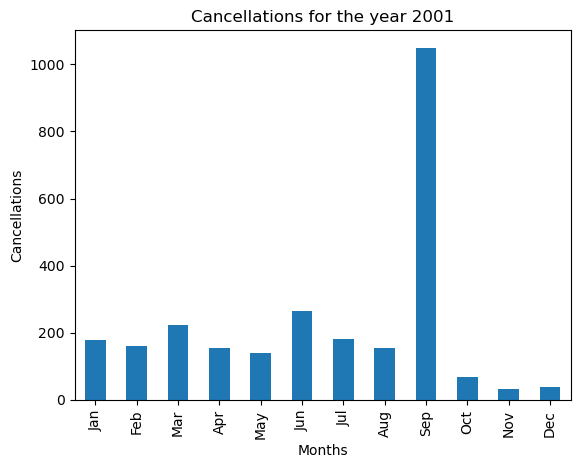

In [12]:
#Defined Function for bar graphs using dataframes.
#------------------------------------------------------------------------------------------------
def cancel(years):
    year = years["Year"].max()
    x_can = years.loc[(years['Cancelled'] == 1)]
    y_mon = x_can.groupby(['Month'])['Cancelled'].value_counts()
    y_mon = pd.DataFrame(y_mon)
    
    y_mon.plot.bar(color='tab:blue', legend=False)
    plt.xlabel("Months")
    plt.ylabel("Cancellations")
    x_axis = np.arange(12)
    
    plt.title(f"Cancellations for the year {year}")
    tick_locations = [value for value in x_axis]
    plt.xticks(tick_locations, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    plt.show()
    return

cancel(year_2001)

In [16]:
year_2008[year_2008['WeatherDelay'] >0]

,Unnamed: 0_x,ActualElapsedTime,AirTime,Date,ArrDelay,ArrTime,CRSArrTime,CRSDepTime,CRSElapsedTime,CancellationCode,...,UniqueCarrier,WeatherDelay,Year,Unnamed: 0_y,Temperature,Precipitation,Rain Fall,Snow Fall,Amount of Snow,Weather
430,430,87.0,48.0,2008-08-02 09:00:00+00:00,37.0,1024.0,947,830,77.0,NaN,...,YV,37.0,2008,75269.0,76.059710,0.047244,0.047244,0.000000,0.0,Heavy Drizzle
1480,1480,90.0,62.0,2008-11-09 18:00:00+00:00,46.0,1930.0,1844,1705,99.0,NaN,...,OH,46.0,2008,77654.0,49.461670,0.000000,0.000000,0.000000,0.0,Partly Cloudy
2298,2298,349.0,325.0,2008-12-06 19:00:00+00:00,74.0,2200.0,2046,1751,355.0,NaN,...,UA,74.0,2008,78303.0,26.541939,0.000000,0.000000,0.000000,0.0,Cloudy
2942,2942,163.0,97.0,2008-01-17 15:00:00+00:00,62.0,1821.0,1719,1526,113.0,NaN,...,DL,1.0,2008,70523.0,27.411331,0.007874,0.000000,0.055118,0.0,Light Snow
3705,3705,169.0,97.0,2008-06-19 17:00:00+00:00,45.0,1924.0,1839,1713,146.0,NaN,...,UA,22.0,2008,74221.0,70.386154,0.000000,0.000000,0.000000,0.0,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
783754,783754,206.0,124.0,2008-06-13 18:00:00+00:00,76.0,2026.0,1910,1724,166.0,NaN,...,NW,18.0,2008,74078.0,95.290215,0.000000,0.000000,0.000000,0.0,Sunny
783806,783806,113.0,34.0,2008-05-31 13:00:00+00:00,53.0,1513.0,1420,1318,62.0,NaN,...,YV,53.0,2008,73761.0,74.781520,0.000000,0.000000,0.000000,0.0,Mainly Sunny
785929,785929,86.0,67.0,2008-09-09 21:00:00+00:00,211.0,2226.0,1855,1720,95.0,NaN,...,OH,211.0,2008,76193.0,82.766460,0.000000,0.000000,0.000000,0.0,Cloudy
786171,786171,126.0,109.0,2008-12-23 21:00:00+00:00,176.0,2326.0,2030,1810,140.0,NaN,...,WN,22.0,2008,78713.0,21.427576,0.000000,0.000000,0.000000,0.0,Partly Cloudy


In [27]:
delay_2008_df['Weather'].value_counts()

Weather
Sunny            232
Mainly Sunny     230
Cloudy           126
Partly Cloudy     84
Light Drizzle     69
Drizzle           62
Light Snow        39
Heavy Drizzle     38
Light Rain        29
Snow              26
Heavy Snow        22
Rain              20
Heavy Rain         2
Name: count, dtype: int64

In [23]:
delay_2008_df = year_2008[year_2008['WeatherDelay'] > 0]
delay_2008_df.Precipitation.value_counts()

Precipitation
0.000000    684
0.007874     30
0.043307     27
0.011811     27
0.003937     22
0.047244     22
0.062992     20
0.015748     19
0.019685     18
0.023622     15
0.027559     14
0.035433     13
0.031496     10
0.110236      7
0.086614      6
0.039370      5
0.082677      5
0.078740      4
0.074803      4
0.070866      4
0.051181      4
0.125984      3
0.169291      2
0.066929      2
0.141732      2
0.165354      1
0.106299      1
0.374016      1
0.145669      1
0.090551      1
0.059055      1
0.122047      1
0.208661      1
0.173228      1
0.480315      1
Name: count, dtype: int64

In [25]:
delay_2008_df['Rain Fall'].value_counts()

Rain Fall
0.000000    749
0.011811     24
0.047244     21
0.007874     20
0.015748     17
0.003937     15
0.023622     15
0.027559     14
0.043307     14
0.035433     13
0.031496     10
0.019685     10
0.110236      7
0.086614      6
0.082677      5
0.078740      4
0.070866      4
0.051181      3
0.039370      3
0.125984      3
0.169291      2
0.141732      2
0.066929      2
0.007874      2
0.062992      2
0.165354      1
0.043307      1
0.074803      1
0.106299      1
0.374016      1
0.145669      1
0.090551      1
0.059055      1
0.122047      1
0.208661      1
0.173228      1
0.480315      1
Name: count, dtype: int64

In [26]:
delay_2008_df['Snow Fall'].value_counts()

Snow Fall
0.000000    892
0.027559     25
0.440945     18
0.055118     14
0.303150     13
0.137795      6
0.082677      5
0.523622      3
0.220472      2
0.330709      1
Name: count, dtype: int64

In [29]:
complete_delay_df = complete_df[complete_df.WeatherDelay > 0]
complete_delay_df

,Unnamed: 0_x,ActualElapsedTime,AirTime,Date,ArrDelay,ArrTime,CRSArrTime,CRSDepTime,CRSElapsedTime,CancellationCode,...,UniqueCarrier,WeatherDelay,Year,Unnamed: 0_y,Temperature,Precipitation,Rain Fall,Snow Fall,Amount of Snow,Weather
1,1,130.0,69.0,2004-09-09 18:00:00+00:00,41.0,2033.0,1952,1805,107.0,NaN,...,OH,18.0,2004,41126.0,82.813515,0.000000,0.0,0.000000,0.000000,Mainly Sunny
44,44,232.0,194.0,2007-02-25 14:00:00+00:00,84.0,1648.0,1524,1250,214.0,NaN,...,XE,66.0,2007,62698.0,23.315540,0.047244,0.0,0.330709,0.131234,Heavy Snow
101,101,167.0,99.0,2003-12-05 10:00:00+00:00,162.0,1230.0,948,850,118.0,NaN,...,DH,114.0,2003,34422.0,24.377182,0.086614,0.0,0.606299,0.196850,Heavy Snow
234,234,357.0,310.0,2005-12-15 18:00:00+00:00,34.0,2136.0,2102,1810,352.0,NaN,...,UA,29.0,2005,52214.0,25.259050,0.023622,0.0,0.165354,0.426509,Snow
422,422,81.0,57.0,2005-07-27 21:00:00+00:00,237.0,2233.0,1836,1708,88.0,NaN,...,UA,210.0,2005,48833.0,96.059020,0.000000,0.0,0.000000,0.000000,Mainly Sunny
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786103,786103,154.0,139.0,2003-07-14 15:00:00+00:00,38.0,1649.0,1611,1435,156.0,NaN,...,NW,38.0,2003,30971.0,78.969154,0.000000,0.0,0.000000,0.000000,Sunny
786171,786171,126.0,109.0,2008-12-23 21:00:00+00:00,176.0,2326.0,2030,1810,140.0,NaN,...,WN,22.0,2008,78713.0,21.427576,0.000000,0.0,0.000000,0.000000,Partly Cloudy
786207,786207,146.0,129.0,2008-02-01 08:00:00+00:00,34.0,1044.0,1010,745,145.0,NaN,...,WN,33.0,2008,70876.0,24.576797,0.000000,0.0,0.000000,0.000000,Cloudy
786350,786350,303.0,266.0,2007-01-16 16:00:00+00:00,76.0,1809.0,1653,1440,313.0,NaN,...,UA,76.0,2007,61740.0,32.892033,0.000000,0.0,0.000000,0.000000,Cloudy


In [35]:
complete_delay_df.columns

Index(['Unnamed: 0_x', 'ActualElapsedTime', 'AirTime', 'Date', 'ArrDelay',
       'ArrTime', 'CRSArrTime', 'CRSDepTime', 'CRSElapsedTime',
       'CancellationCode', 'Cancelled', 'CarrierDelay', 'DayOfWeek',
       'DayofMonth', 'DepDelay', 'DepTime', 'Dest', 'Distance', 'Diverted',
       'FlightNum', 'LateAircraftDelay', 'Month', 'NASDelay', 'Origin',
       'SecurityDelay', 'TailNum', 'TaxiIn', 'TaxiOut', 'UniqueCarrier',
       'WeatherDelay', 'Year', 'Unnamed: 0_y', 'Temperature', 'Precipitation',
       'Rain Fall', 'Snow Fall', 'Amount of Snow', 'Weather'],
      dtype='object')

In [34]:
complete_delay_df.ArrDelay.value_counts()

ArrDelay
20.0      92
25.0      86
21.0      82
30.0      80
22.0      80
          ..
321.0      1
1025.0     1
514.0      1
364.0      1
310.0      1
Name: count, Length: 373, dtype: int64

In [30]:
complete_delay_df.Weather.value_counts()

Weather
Mainly Sunny     1355
Sunny            1126
Cloudy            955
Light Drizzle     707
Partly Cloudy     664
Snow              388
Light Rain        354
Drizzle           354
Light Snow        322
Heavy Snow        236
Rain              195
Heavy Drizzle     193
Heavy Rain         16
Name: count, dtype: int64